# Speech Recognition Model Training from Scratch

This notebook explains the components of training an Automatic Speech Recognition (ASR) system using the PyTorch library. The model uses the LibriSpeech dataset, processes audio data, and employs a simple Long Shert Term Memory (LSTM) netowrk to recognize spoken English.

[LibriSpeech](https://www.openslr.org/12) is a corpus of approximately 1,000 hours of English speech derived from audiobooks in the LibriVox project, which features read speech from a variety of audiobooks. The dataset includes corresponding transcripts, making it widely used for training and evaluating automatic speech recognition (ASR) systems.

### Import Libraries
Here, we load all the necessary libraries that we'll use throughout the notebook. This includes libraries for handling audio data, training neural networks, and visualizing data.

In [ ]:
!pip install jiwer

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
import pandas as pd
from jiwer import wer
from torchaudio.datasets import LIBRISPEECH
from torch.utils.data import DataLoader
from torchaudio.transforms import MelSpectrogram, Resample
import matplotlib.pyplot as plt
from IPython.display import Audio, display

### Configuration and Loading the Dataset
We configure essential parameters such as the directory of the dataset, device configuration for training and load the dataset. `dev-clean` and `test-clean` data set need to be downloaded from [here](https://www.openslr.org/12) and saved in the data folder of this notebook

In [ ]:
!wget -P ./data https://openslr.magicdatatech.com/resources/12/dev-clean.tar.gz
!wget -P ./data https://openslr.magicdatatech.com/resources/12/test-clean.tar.gz
!tar -xzf ./data/dev-clean.tar.gz -C ./data/
!tar -xzf ./data/test-clean.tar.gz -C ./data/

In [ ]:
# Data parameters
data_folder = "./data"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load datasets
train_dataset = LIBRISPEECH(root=data_folder, url="dev-clean", download=False)
test_dataset = LIBRISPEECH(root=data_folder, url="test-clean", download=False)

### Explore Audio Data
Before diving into training, let's visualize and listen to a few audio samples. This helps to understand the data and ensure it's loaded correctly.

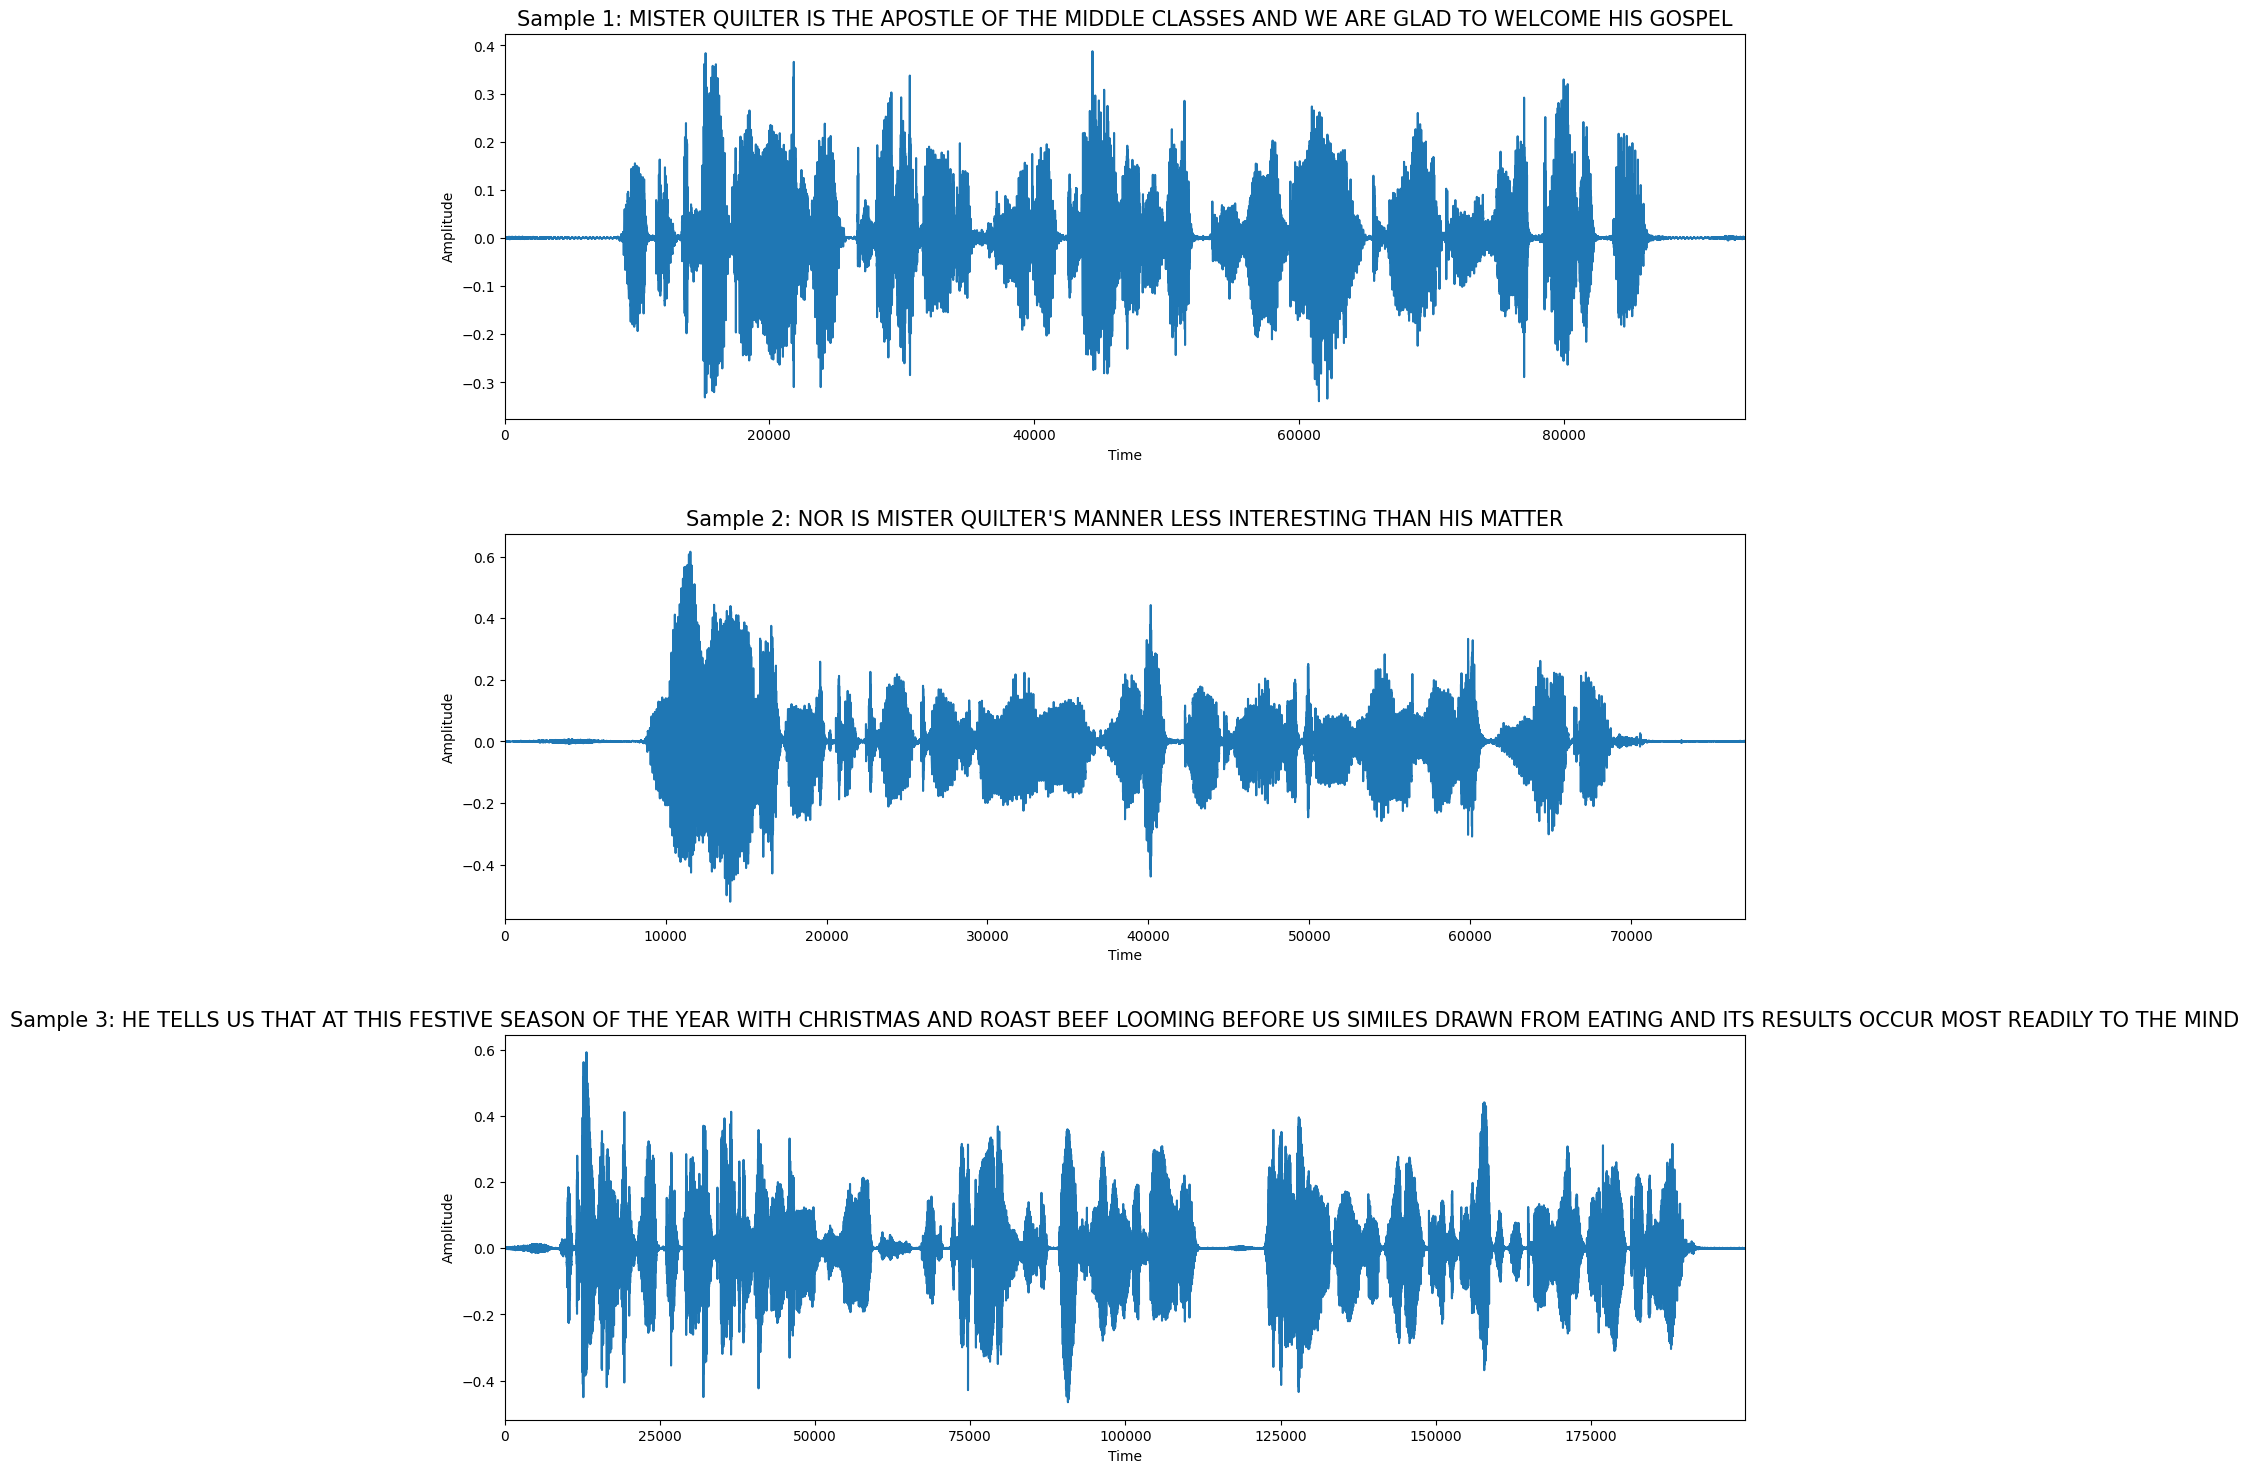

In [17]:
def plot_and_play_audio(samples=3):
    # Increase the figure size and the space between plots
    fig, axes = plt.subplots(nrows=samples, figsize=(16, 6 * samples))
    fig.subplots_adjust(hspace=0.3)  # Adjust vertical spacing between plots
    for i, (waveform, sample_rate, utterance, _, _, _) in enumerate(train_dataset):
        if i >= samples:
            break
        ax = axes[i] if samples > 1 else axes  # Adjust for case when samples is 1
        ax.plot(waveform.t().numpy())
        ax.set_title(f'Sample {i+1}: {utterance}', fontsize=15)  # Increase font size if necessary
        ax.set_xlim([0, waveform.shape[1]])
        ax.set_xlabel('Time')
        ax.set_ylabel('Amplitude')
        display(Audio(waveform.numpy(), rate=sample_rate))

    plt.show()  # Ensure all plots are rendered
# Visualize and listen to a few samples from the dataset
plot_and_play_audio(samples=3)


### Prepare Data for Training and Testing
We define a collate function to process and batch the data, making it ready for training.

In [ ]:
def collate_fn(batch):
    tensors, targets, input_lengths, target_lengths, utterances = [], [], [], [], []
    resample_transform = Resample(orig_freq=16000, new_freq=16000)  # Define resample to standardize to 16 kHz
    for waveform, sample_rate, utterance, _, _, _ in batch:
        if sample_rate != 16000:
            waveform = resample_transform(waveform)  # Resample to 16 kHz if needed
        mel_spectrogram = MelSpectrogram()(waveform).squeeze(0).transpose(0, 1)
        tensors.append(mel_spectrogram)
        target = torch.tensor([ord(c) - ord('a') for c in utterance.lower() if c.isalpha()])
        targets.append(target)
        input_lengths.append(mel_spectrogram.shape[0])
        target_lengths.append(len(target))
        utterances.append(utterance)
    tensors = nn.utils.rnn.pad_sequence(tensors, batch_first=True).to(device)
    targets = nn.utils.rnn.pad_sequence(targets, batch_first=True).to(device)
    input_lengths = torch.tensor(input_lengths).to(device)
    target_lengths = torch.tensor(target_lengths).to(device)
    return tensors, targets, input_lengths, target_lengths, utterances

train_loader = DataLoader(dataset=train_dataset, batch_size=16, collate_fn=collate_fn, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=16, collate_fn=collate_fn, shuffle=False)


### Example Tensor Visualization
Demonstrate how an audio signal sampled at 16kHz is represented as a tensor.

In [ ]:
waveform, sample_rate, _, _, _, _ = train_dataset[0]
if sample_rate != 16000:
    waveform = resample_transform(waveform)
print(f"Sample waveform tensor at 16kHz: {waveform}")
print(f'Tensor shape: {waveform.shape}')

In the shape of the tensor, the first dimension represents the number of audio channels (which is 1 for mono channel audio) and the second dimension represents the number of discrete measurements over time.

### Define the ASR Model
A simple RNN model using LSTM is defined for the ASR task.

In [ ]:
class ASRModel(nn.Module):
    def __init__(self):
        super(ASRModel, self).__init__()
        self.lstm = nn.LSTM(input_size=128, hidden_size=128, num_layers=1, batch_first=True)
        self.fc = nn.Linear(128, 26)  # Assuming 26 letters in the alphabet

    def forward(self, x):
        output, _ = self.lstm(x)
        output = self.fc(output)
        return output

model = ASRModel().to(device)


### Training and Evaluation
Initialize the training parameters, loss function and optimizer and then train the model, and evaluate its performance on the test dataset using Word Error Rate (WER).

In [ ]:
# Hyperparameters
learning_rate = 0.0001
batch_size = 16
max_steps_per_epoch = 10  # Limit the number of training steps
epochs = 5

# Loss and optimizer
criterion = nn.CTCLoss(blank=25, zero_infinity=True)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Function to decode model output
def decode_output(output):
    output = output.transpose(0, 1)  # Make sure it is (batch, time, n_class)
    probabilities, max_indices = torch.max(output, 2)
    return ''.join([chr(i + ord('a')) for i in max_indices[0]])

# Training loop
model.train()
for epoch in range(5):
    for i, (inputs, targets, input_lengths, target_lengths, _) in enumerate(train_loader):
        if i >= max_steps_per_epoch:
            break
        optimizer.zero_grad()
        outputs = model(inputs)  # (batch, time, n_class)
        outputs = torch.nn.functional.log_softmax(outputs, dim=2)
        input_lengths = torch.clamp(input_lengths, max=outputs.shape[1])
        loss = criterion(outputs.permute(1, 0, 2), targets, input_lengths, target_lengths)
        loss.backward()
        optimizer.step()
        if (i + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

# Testing loop
model.eval()
results = []
with torch.no_grad():
    for i, (inputs, _, _, _, utterances) in enumerate(test_loader):
        if i >= max_steps_per_epoch:
            break
        outputs = model(inputs)
        outputs = torch.nn.functional.log_softmax(outputs, dim=2)
        predictions = [decode_output(outputs[j].unsqueeze(0)) for j in range(outputs.shape[0])]

        for utterance, prediction in zip(utterances, predictions):
            error = wer(utterance, prediction)
            results.append({'Ground Truth': utterance, 'Prediction': prediction, 'WER': error})

# Convert results to a DataFrame
results_df = pd.DataFrame(results)
print(results_df.head())

print("Training and testing completed")

The WER scores observed in this notebook are notably high, primarily due to the limited training. We trained the model for only 5 epochs and on a small fraction of the data.
However, during the training process, we observed that the validation loss decreases over the epochs. This trend is a positive indicator of the LSTM model learning and improving. The validation loss provides a measure of the model's performance on a subset of the dataset that is not used for training. As the model learns to generalize better from the training data, it performs more effectively on the validation data, resulting in lower validation loss values.

#### Explanation for Prediction of 'z'
The consistent prediction of a single character like 'z' across different inputs suggests that the model is underfitting could be attributed to:
- Training Duration: The model was trained for only 5 epochs for illustration purposes which appears insufficient. Increasing the number of training epochs could help. More epochs would allow the model more opportunities to learn from the data, potentially leading to better understanding and more accurate predictions.
- Model Complexity: The model might not be complex enough to learn the features required for a robust speech recognition system. Increasing the complexity of the model or using a more sophisticated architecture tailored for ASR might be necessary.

### Conclusion
In this notebook, we set up, trained, and evaluating a simple Automatic Speech Recognition (ASR) model using the PyTorch library and the LibriSpeech dataset. In a real-world scenario, achieving a low WER requires training a more robust ASR model involving steps such as:
- Utilizing more Training Data
- Extended Training Duration
- Model Complexity
- Regularization and Optimization
- Fine-tuning and Transfer Learning
- Data Augmentation